In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [5]:
# --- Analytical calculation ---

def calculate_analytical_Vm(params, freqs):
    """Calculate the analytical transfer function amplitude."""
    Rm = params['Rm']
    Ri = params['Ri']
    Cm = params['Cm']
    d = params['d']
    ds = params['ds']
    l1 = params['l1']
    l2 = params['l2']
    s_in = params['s_in']

    omega = 2 * np.pi * freqs
    omega[0] += 1e-9

    tau_m = Rm * Cm
    lambda_ = np.sqrt((d * Rm) / (4 * Ri))
    L1 = l1 / lambda_
    L2 = l2 / lambda_
    W = omega * tau_m
    q = np.sqrt(1 + 1j * W)

    Ys = np.pi * ds**2 * (1/Rm) * q**2
    G_inf = np.pi * d**2 / (4 * Ri * lambda_)
    Y_inf = q * G_inf
    Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

    numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
    T_p = numerator / Y_in_total

    return 1e3 * np.abs(T_p)  # mV


standard_neuron_parameters = {
    'Rm': 3.0,
    'Ri': 1.5,
    'Cm': 0.01,
    'd': 2e-6,
    'ds': 20e-6,
    'l1': 670e-6,
    'l2': 330e-6,
    's_in': (1e-15)**2
}

frequencies = np.logspace(0, 3.4, 1000)


def generate_V_m_matrix(l_fixed, params, freqs):
    if l_fixed > 0.4e-3:
        l_vary = np.linspace(0, 1.77e-3, 50)
    else:
        l_vary = np.linspace(0, l_fixed, 50)

    V_m_matrix = np.zeros((len(l_vary), len(freqs)))

    test_params = params.copy()
    test_params['l2'] = l_fixed

    for i, lv in enumerate(l_vary):
        test_params['l1'] = lv
        V_m_matrix[i] = calculate_analytical_Vm(test_params, freqs)

    return V_m_matrix, l_vary


# --- Compute analytical matrices ---
l_fixed_long  = 0.6e-3
l_fixed_short = 0.2e-3

V_m_matrix_long,  l_vary_long  = generate_V_m_matrix(l_fixed_long,  standard_neuron_parameters, frequencies)
V_m_matrix_short, l_vary_short = generate_V_m_matrix(l_fixed_short, standard_neuron_parameters, frequencies)

delta_l_long_ana  = abs(l_vary_long  - l_fixed_long)  * 1e6
delta_l_short_ana = abs(l_vary_short - l_fixed_short) * 1e6

In [12]:
# --- Simulation data ---

# --- Load vmem simulation data ---
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

# --- Separate out short and long cells ---

l_short_limit = 200
l_long_limit = 600

short_cells = []
long_cells = []

for cell_name, data in vmem_amp_data.items():
    l1 = data['upper_z_endpoint']
    l2 = abs(data['bottom_z_endpoint'])
    if l2 <= l_short_limit:
        if abs(l1 - l2) < 200:
            short_cells.append(cell_name)
    elif l2 >= l_long_limit:
        long_cells.append(cell_name)

# --- Extract l1 values for each group ---
l1_for_long_cells  = np.sort([vmem_amp_data[c]['upper_z_endpoint'] for c in long_cells])
l1_for_short_cells = np.sort([vmem_amp_data[c]['upper_z_endpoint'] for c in short_cells])

# --- Compute Δl for every cell ---
delta_l = {
    name: abs(data["upper_z_endpoint"] - abs(data["bottom_z_endpoint"]))
    for name, data in vmem_amp_data.items()
}

def average_by_delta_l(cell_list):
    """
    Groups cells by identical Δl and averages soma_amp across those cells.
    Returns:
        delta_l_unique  : sorted unique Δl values
        averaged_matrix : matrix (#unique Δl, #freqs)
    """
    # temporary storage: Δl → list of Vm curves
    groups = defaultdict(list)

    for name in cell_list:
        dl = delta_l[name]
        groups[dl].append(vmem_amp_data[name]['soma_amp'])

    # sort Δl values
    delta_l_unique = np.array(sorted(groups.keys()))

    # average curves for each Δl group
    averaged_matrix = np.array([
        np.mean(groups[dl], axis=0)
        for dl in delta_l_unique
    ])

    return delta_l_unique, averaged_matrix

# --- Build Vm matrices with averaging if several cells have the same Δl ---

delta_l_long,  long_matrix  = average_by_delta_l(long_cells)
delta_l_short, short_matrix = average_by_delta_l(short_cells)

# --- Frequencies for simulation data ---
frequencies_sim = vmem_amp_data['L1_DAC_bNAC219_1']['freq']

<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:27: SyntaxWarning: invalid escape sequence '\h'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_61417/2041657994.py:17: SyntaxWarning: invalid escape sequence '\h'
  fig.colorbar(pcm, ax=axes[0, 0], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_61417/2041657994.py:27: SyntaxWarning: invalid escape sequence '\h'
  fig.colorbar(pcm, ax=axes[0, 1], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_61417/2041657994.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm = axes[0, 0].pcolor

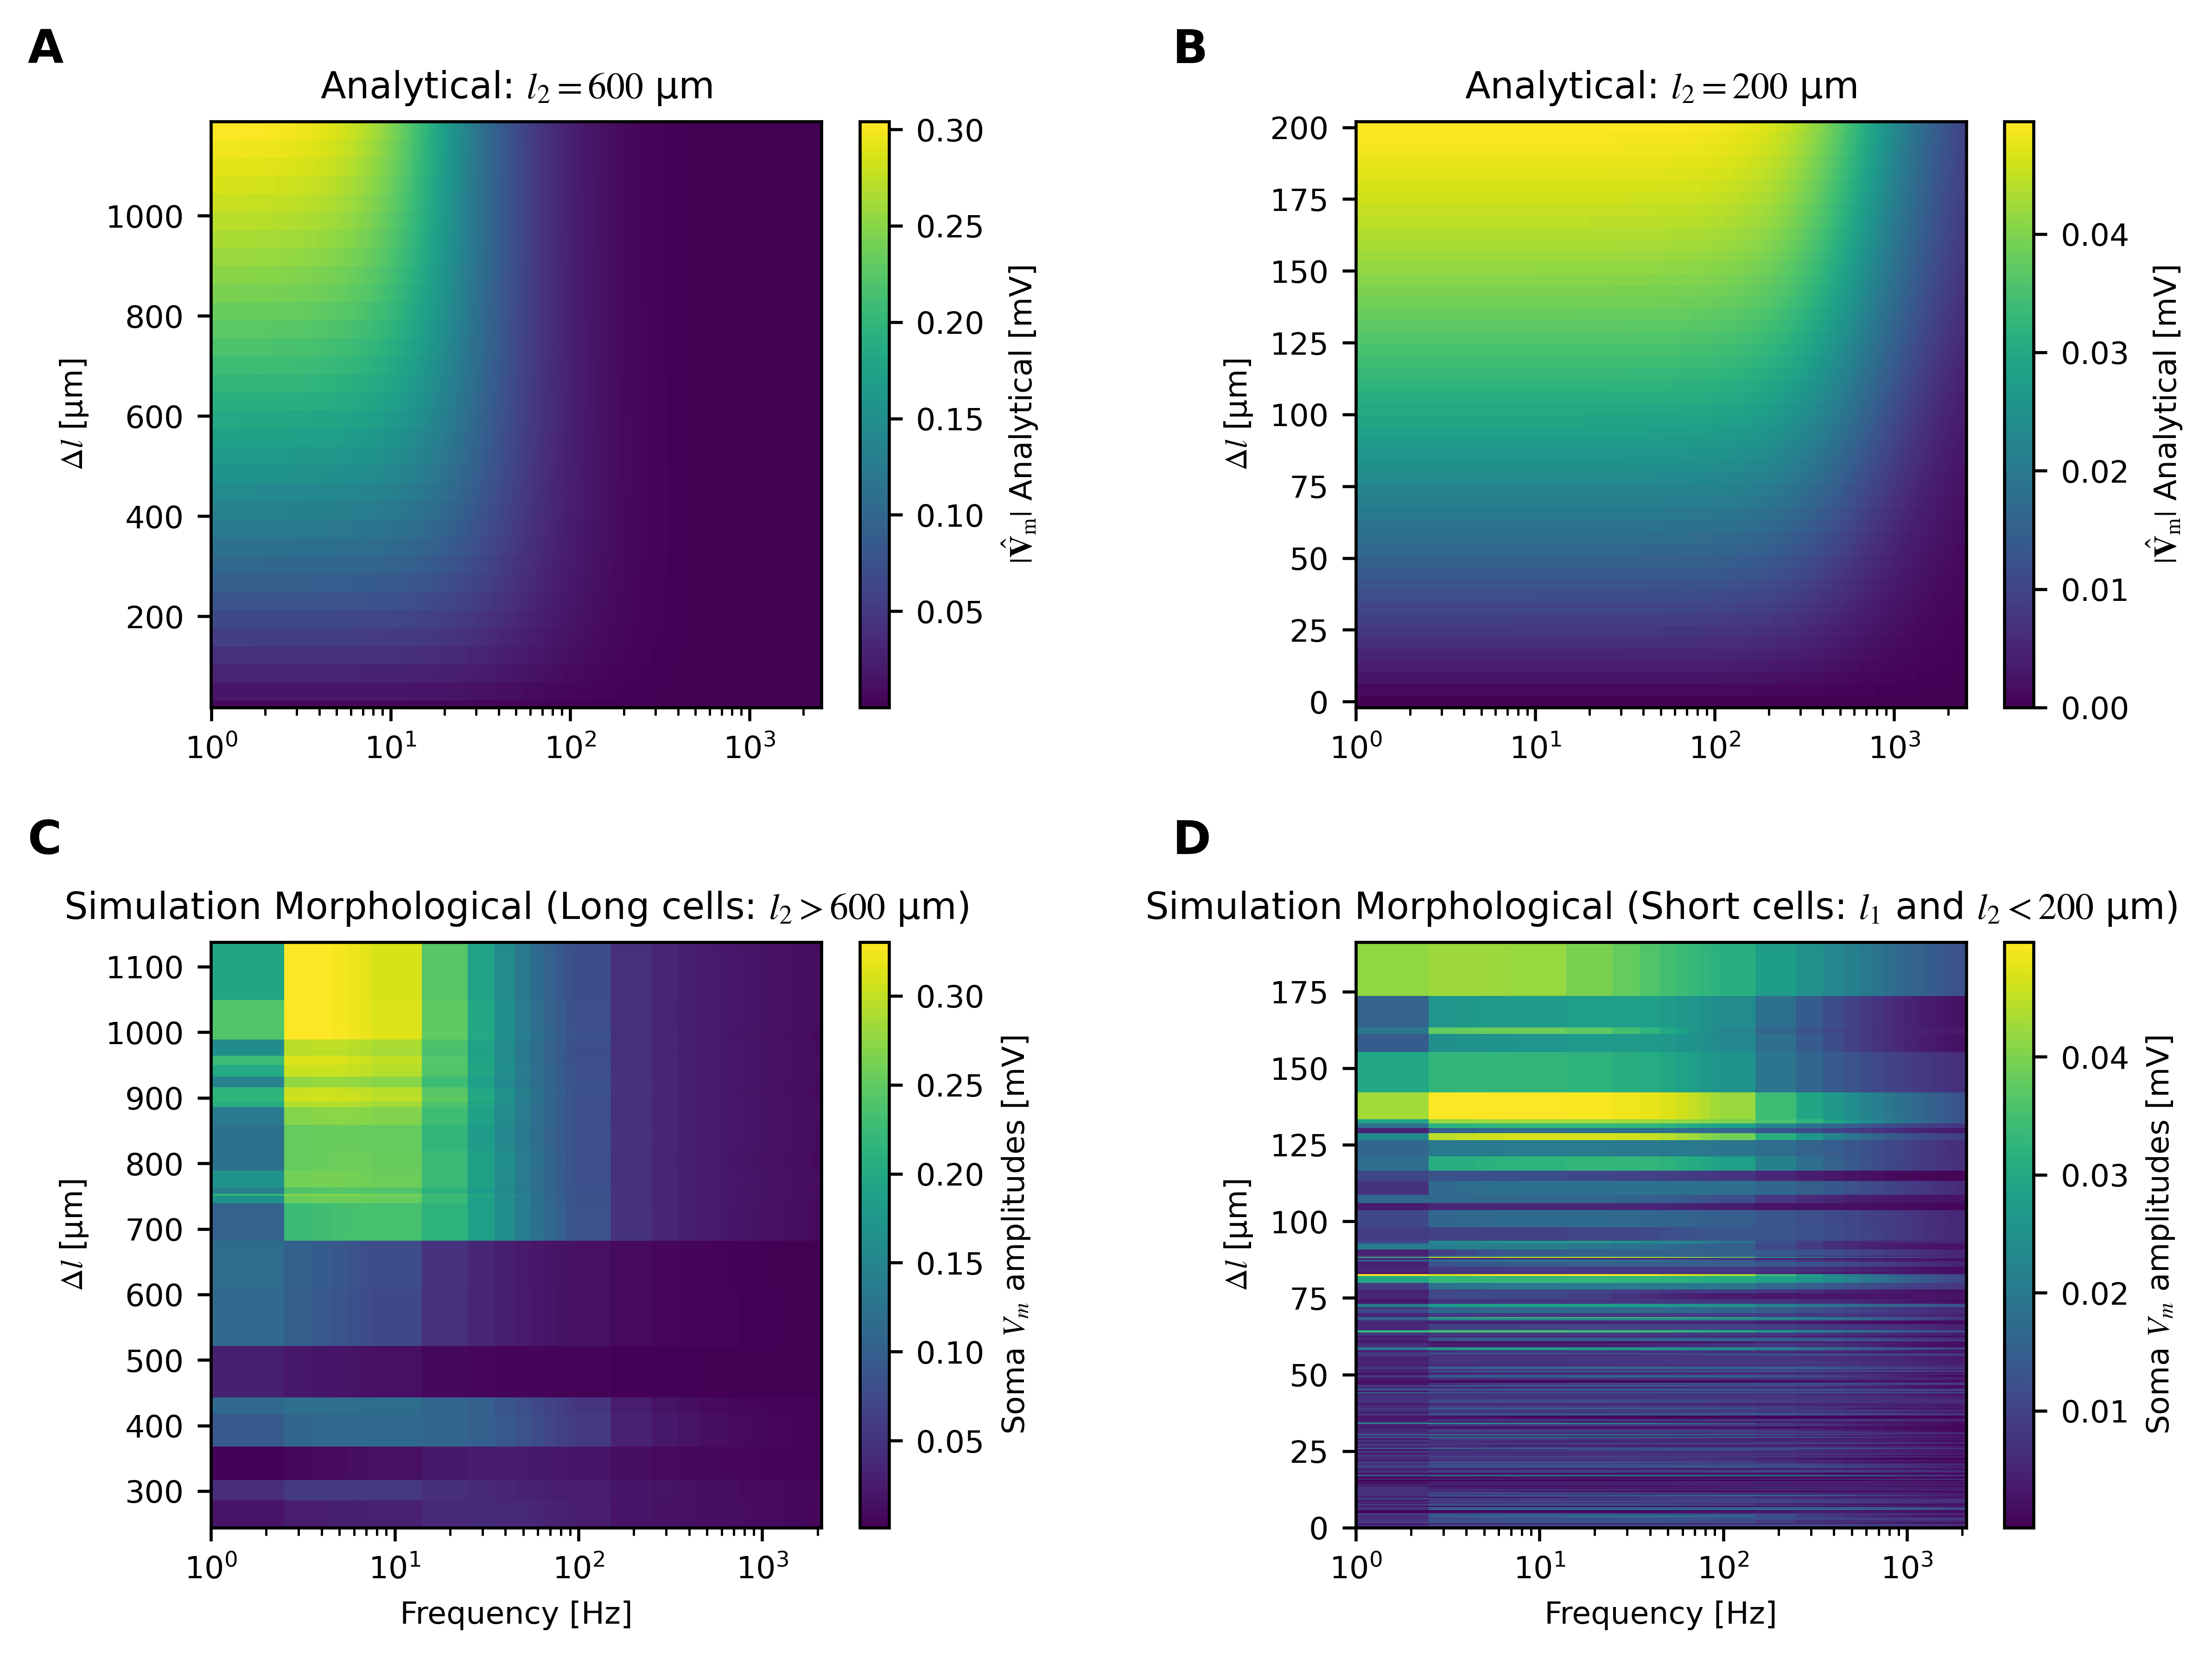

In [14]:
# --- Plotting ---

fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# ---------------------------------------------------------
#  Row 1 — ANALYTICAL
# ---------------------------------------------------------

# --- Analytical Long ---
pcm = axes[0, 0].pcolormesh(
    frequencies, delta_l_long_ana, V_m_matrix_long,
    shading='auto', cmap='viridis'
)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title(f"Analytical: $l_2 = {l_fixed_long*1e6:.0f}$ µm")
axes[0, 0].set_ylabel(r'$\Delta l$ [µm]')
fig.colorbar(pcm, ax=axes[0, 0], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')

# --- Analytical Short ---
pcm = axes[0, 1].pcolormesh(
    frequencies, delta_l_short_ana, V_m_matrix_short,
    shading='auto', cmap='viridis'
)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title(f"Analytical: $l_2 = {l_fixed_short*1e6:.0f}$ µm")
axes[0, 1].set_ylabel(r'$\Delta l$ [µm]')
fig.colorbar(pcm, ax=axes[0, 1], label='$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]')


# ---------------------------------------------------------
#  Row 2 — SIMULATION
# ---------------------------------------------------------

# --- Simulation Long ---
pcm = axes[1, 0].pcolormesh(
    frequencies_sim, delta_l_long, long_matrix,
    shading='auto', cmap='viridis'
)
axes[1, 0].set_xscale('log')
axes[1, 0].set_title(f"Simulation Morphological (Long cells: $l_2 > {l_long_limit}$ µm)")
axes[1, 0].set_xlabel("Frequency [Hz]")
axes[1, 0].set_ylabel(r'$\Delta l$ [µm]')
axes[1, 0].set_xlim(left = 1, right = 2100)
fig.colorbar(pcm, ax=axes[1, 0], label='Soma $V_m$ amplitudes [mV]')

# --- Simulation Short ---
pcm = axes[1, 1].pcolormesh(
    frequencies_sim, delta_l_short, short_matrix,
    shading='auto', cmap='viridis'
)
axes[1, 1].set_xscale('log')
axes[1, 1].set_title(f"Simulation Morphological (Short cells: $l_1$ and $l_2 < {l_short_limit}$ µm)")
axes[1, 1].set_xlabel("Frequency [Hz]")
axes[1, 1].set_ylabel(r'$\Delta l$ [µm]')
axes[1, 1].set_xlim(left = 1, right = 2100)
fig.colorbar(pcm, ax=axes[1, 1], label='Soma $V_m$ amplitudes [mV]')

axes[0,0].text(-0.3, 1.10, 'A', transform=axes[0,0].transAxes, fontsize=12, fontweight='bold')
axes[0,1].text(-0.3, 1.10, 'B', transform=axes[0,1].transAxes, fontsize=12, fontweight='bold')
axes[1,0].text(-0.3, 1.15, 'C', transform=axes[1,0].transAxes, fontsize=12, fontweight='bold')
axes[1,1].text(-0.3, 1.15, 'D', transform=axes[1,1].transAxes, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace= 0.4)
plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/transfer/fig11.pdf', bbox_inches="tight")
plt.show()